In [ ]:
import io
import pandas as pd
#from google.colab import files

import numpy as np
import pandas as pd
import math
import json
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn import preprocessing, tree
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV, ParameterGrid

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

**Load Data**

In [ ]:
GBID = pd.read_json('./GB_category_id.json')
GBComments = pd.read_csv('./GBcomments.csv', sep = ',', error_bad_lines=False, engine= 'python')
GBvideos = pd.read_csv('./GBvideos.csv', sep = ',', error_bad_lines=False, engine= 'python')
USID = pd.read_json('./US_category_id.json')
USComments = pd.read_csv('./UScomments.csv', sep = ',', error_bad_lines=False, engine= 'python')
USVideos = pd.read_csv('./USvideos.csv', sep = ',', error_bad_lines=False, engine= 'python')

<ipython-input-2-598f60a4c664>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  GBComments = pd.read_csv('./GBcomments.csv', sep = ',', error_bad_lines=False, engine= 'python')
Skipping line 76763: ',' expected after '"'
Skipping line 79235: unexpected end of data
<ipython-input-2-598f60a4c664>:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  GBvideos = pd.read_csv('./GBvideos.csv', sep = ',', error_bad_lines=False, engine= 'python')
Skipping line 2398: Expected 11 fields in line 2398, saw 21
Skipping line 2797: Expected 11 fields in line 2797, saw 21
<ipython-input-2-598f60a4c664>:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  USComments = pd.read_csv('./UScomments.csv', sep = ',', error_bad_lines=False

In [ ]:
# Load and read json files
with open('GB_category_id.json') as f:
    gb_category_data = json.load(f)
with open('US_category_id.json') as f:
    us_category_data = json.load(f)

#Extract only item part
gb_category_df = pd.DataFrame(gb_category_data['items'])
us_category_df = pd.DataFrame(us_category_data['items'])

gb_category_df['category_id'] = gb_category_df['id'].astype(int)
gb_category_df['category_title'] = gb_category_df['snippet'].apply(lambda x: x['title'])
gb_category_df['from'] = 'gb'

us_category_df['category_id'] = us_category_df['id'].astype(int)
us_category_df['category_title'] = us_category_df['snippet'].apply(lambda x: x['title'])
us_category_df['from'] = 'us'

gb_category_df = gb_category_df[['category_id', 'category_title', 'from']]
us_category_df = us_category_df[['category_id', 'category_title', 'from']]

gbVid_df = GBvideos.merge(gb_category_df, on='category_id', how='left')
usVid_df = USVideos.merge(us_category_df, on='category_id', how='left')

unioned_videos = pd.concat([gbVid_df, usVid_df], ignore_index=True)

In [ ]:
category_list = unioned_videos['category_title'].unique()
category_num = len(category_list)

In [ ]:
print('List of Categories: ', category_list)
print('Numbers of Categories: ', category_num)

List of Categories:  ['Science & Technology' 'Entertainment' 'Film & Animation' 'Howto & Style'
 'Sports' 'People & Blogs' 'Music' 'Comedy' 'Education' 'News & Politics'
 'Gaming' 'Autos & Vehicles' 'Pets & Animals' nan 'Travel & Events'
 'Nonprofits & Activism' 'Shows']
Numbers of Categories:  17


Thesis: There is 17 types of categories to assign for videos. We want to explore and check whether video creators have assigned video categories well, which are directly related to how videos in YouTube can be organized based on the given categories. When we do clustering with 17 clusters and if it has highest silhouette score, it does indicate given categories are easy and not confused to assign and creators have assigned well. However, if the other number which is far from 17 has highest silhuoette score, we think that it means we need to remove or combine some similar categories to make Youtube be more organized.

In [ ]:
USComments.head()

,video_id,comment_text,likes,replies
0,XpVt6Z1Gjjo,Logan Paul it's yo big day ‼️‼️‼️,4,0
1,XpVt6Z1Gjjo,I've been following you from the start of your...,3,0
2,XpVt6Z1Gjjo,Say hi to Kong and maverick for me,3,0
3,XpVt6Z1Gjjo,MY FAN . attendance,3,0
4,XpVt6Z1Gjjo,trending 😉,3,0


In [ ]:
USVideos.head()

,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_total,thumbnail_link,date
0,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,13.09
1,K4wEI5zhHB0,iPhone X — Introducing iPhone X — Apple,Apple,28,Apple|iPhone 10|iPhone Ten|iPhone|Portrait Lig...,7860119,185853,26679,0,https://i.ytimg.com/vi/K4wEI5zhHB0/default.jpg,13.09
2,cLdxuaxaQwc,My Response,PewDiePie,22,[none],5845909,576597,39774,170708,https://i.ytimg.com/vi/cLdxuaxaQwc/default.jpg,13.09
3,WYYvHb03Eog,Apple iPhone X first look,The Verge,28,apple iphone x hands on|Apple iPhone X|iPhone ...,2642103,24975,4542,12829,https://i.ytimg.com/vi/WYYvHb03Eog/default.jpg,13.09
4,sjlHnJvXdQs,iPhone X (parody),jacksfilms,23,jacksfilms|parody|parodies|iphone|iphone x|iph...,1168130,96666,568,6666,https://i.ytimg.com/vi/sjlHnJvXdQs/default.jpg,13.09


**Start Analysis**

Goal: Using KMeans clustering, classify Youtube video category based on their features

Features ready to be used (or just normalization):
- Views (Normalize)
- Likes (Normalize)
- Dislikes (Normalize)
- Comment_total (Normalize)
- Proportion of long comments (Optional)
  - From all the comments, take its 75th percentile to determine the cutoff for long comments

Features that needs to be processed to be used:
- Word based variables:
  - title
  - channel_title
  - tags
- Approach 1:
  - Tokenize each features, vectorize each words in features
  - Average their vectorized values and use it as a feature for clustering
  - **Pro**: easy to do
  - **Con**: averaging the vectorized values diminishes the meaning of each word. This isn't necessarily keyword based analysis, and usually, youtube videos' categories are more easily classified by what kind of keyword it contains
- **Approach 2 (Implemented below)**:
  - For each categories of videos, specify the most important words for a certain category (20)
    - For instance, we would be getting some keywords like Apple, Iphone, MacBook as important keywords for category that corresponds to tech
  - Create one-hot encoding columns for all the categories, and grant 0 or 1 based on if any of the word from (title,channel_title,tag) contain one of the most important terms from that category
  - **Pro**: Likely more effective and easy to present to the class (can also tell what kinds of words were more common to each categories)
    - Can use WordCloud model (visually easier to represent it to the class) what kind of word is more common in certain category


In [ ]:
#Video data combined:
Videos_Combined = pd.concat([USVideos, GBvideos], ignore_index=True)
Videos_Combined.head()

,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_total,thumbnail_link,date
0,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,13.09
1,K4wEI5zhHB0,iPhone X — Introducing iPhone X — Apple,Apple,28,Apple|iPhone 10|iPhone Ten|iPhone|Portrait Lig...,7860119,185853,26679,0,https://i.ytimg.com/vi/K4wEI5zhHB0/default.jpg,13.09
2,cLdxuaxaQwc,My Response,PewDiePie,22,[none],5845909,576597,39774,170708,https://i.ytimg.com/vi/cLdxuaxaQwc/default.jpg,13.09
3,WYYvHb03Eog,Apple iPhone X first look,The Verge,28,apple iphone x hands on|Apple iPhone X|iPhone ...,2642103,24975,4542,12829,https://i.ytimg.com/vi/WYYvHb03Eog/default.jpg,13.09
4,sjlHnJvXdQs,iPhone X (parody),jacksfilms,23,jacksfilms|parody|parodies|iphone|iphone x|iph...,1168130,96666,568,6666,https://i.ytimg.com/vi/sjlHnJvXdQs/default.jpg,13.09


In [ ]:
#Using Approach 2:

#Tokenize title
import pandas as pd

def tokenize_columns(row):
    # Tokenize 'title' and 'channel_title' by space
    title_tokens = row['title'].lower().split()
    channel_tokens = row['channel_title'].lower().split()

    # Tokenize 'tags' by '|'
    tag_tokens = row['tags'].lower().split('|') if isinstance(row['tags'], str) else []
    #comment_tokens = row['comment_text'].lower().split() if isinstance(row['comment_text'], str) else []

    # Combine all tokens into a single list
    all_tokens = title_tokens + channel_tokens + tag_tokens #+ comment_tokens

    return all_tokens

# Assuming 'df' is your DataFrame
Videos_Combined['tokenized_words'] = Videos_Combined.apply(tokenize_columns, axis=1)

# Display the updated DataFrame
tokens_by_category = Videos_Combined.groupby('category_id')['tokenized_words'].sum()
tokens_by_category

category_id
1     [the, disaster, artist, |, official, trailer, ...
2     [last, week, tonight, with, john, oliver, s04e...
10    [fergie, -, you, already, know, ft., nicki, mi...
15    [更なるフィット感を追求するねこ。-maru, wishes, for, more, fit...
17    [chargers, vs., broncos, |, nfl, week, 1, game...
19    [salted, egg, crab!, street, food, tour, of, o...
20    [season, 21, preview:, white, people, renovati...
22    [my, response, pewdiepie, [none], attacked, by...
23    [iphone, x, (parody), jacksfilms, jacksfilms, ...
24    [1, year, of, vlogging, --, how, logan, paul, ...
25    [hurricane, irma, death, toll, rises, to, 10, ...
26    [juicy, chicken, breast, -, you, suck, at, coo...
27    [what's, actually, the, plane, of, the, future...
28    [iphone, x, —, introducing, iphone, x, —, appl...
29    [willow's, birthday, johns, hopkins, all, chil...
43    [pixel, 2:, squeeze, to, access, features, (cn...
Name: tokenized_words, dtype: object

In [ ]:
from collections import Counter
temp = tokens_by_category.apply(Counter)
temp2 = temp.apply(lambda x: [word for word, count in Counter(x).most_common(30)])
temp2

category_id
1     [trailer, the, |, official, -, film, movie, fo...
2     [-, car, bmw, to, make, how to, the, colinfurz...
10    [-, the, video), (official, music, pop, you, r...
15    [cat, animals, the, brave, kitten, wild, simon...
17    [|, football, highlights, soccer, -, the, 2017...
19    [food, street, in, tour, chinese, spicy, the, ...
20    [-, nintendo, the, ubisoft, trailer, game, gam...
22    [the, |, vlog, my, [none], to, 2017, a, in, i,...
23    [funny, comedy, the, humor, jimmy, sketch, a, ...
24    [the, |, -, trailer, funny, with, comedy, to, ...
25    [news, the, bbc, vox, |, on, in, vegas, of, la...
26    [|, makeup, beauty, tutorial, how to, the, to,...
27    [the, of, science, education, why, life, a, in...
28    [the, science, iphone, apple, to, -, google, t...
29    [|, the, aarp, [none], of, -, with, don, xq, c...
43    [squeeze, pixel, 2:, to, access, features, (cn...
Name: tokenized_words, dtype: object

In [ ]:
#Further process the list by getting rid of meaningless tokens
words_to_remove = {'-', '|', '[none]', 'the', 'a', 'of', 'to', 'on', 'in'}

# Process each set by removing specified words
processed_sets = temp2.apply(lambda word_set: [word for word in word_set if word not in words_to_remove])
processed_sets

category_id
1     [trailer, official, film, movie, fox, cinemasi...
2     [car, bmw, make, how to, colinfurze, colin, fu...
10    [video), (official, music, pop, you, records, ...
15    [cat, animals, brave, kitten, wild, simon's, t...
17    [football, highlights, soccer, 2017, sports, n...
19    [food, street, tour, chinese, spicy, travel, n...
20    [nintendo, ubisoft, trailer, game, gameplay, g...
22    [vlog, my, 2017, i, with, makeup, funny, grace...
23    [funny, comedy, humor, jimmy, sketch, talk sho...
24    [trailer, funny, with, comedy, celebrity, show...
25    [news, bbc, vox, vegas, las, shooting, cbs, hu...
26    [makeup, beauty, tutorial, how to, recipe, hal...
27    [science, education, why, life, interesting, h...
28    [science, iphone, apple, google, tech, unboxin...
29    [aarp, with, don, xq, cancer, freedom, interna...
43    [squeeze, pixel, 2:, access, features, (cnet, ...
Name: tokenized_words, dtype: object

In [ ]:
Videos_Combined['tokenized_words_set'] = Videos_Combined['tokenized_words'].apply(lambda x: list(set(x)))

# for index, words_list in processed_sets.iteritems():
#     print(index, words_list)
newDF = Videos_Combined[['video_id', 'tokenized_words_set']]
newDF

,video_id,tokenized_words_set
0,XpVt6Z1Gjjo,"[year, vlogs, youtube, logan paul vlog, logan ..."
1,K4wEI5zhHB0,"[augmented reality, camera, iphone, iphone 10,..."
2,cLdxuaxaQwc,"[[none], my, response, pewdiepie]"
3,WYYvHb03Eog,"[apple iphone x event, apple iphone x, ios 11,..."
4,sjlHnJvXdQs,"[parody, iphone, x, iphone x, emoji, (parody),..."
...,...,...
15980,T2RUYYs8Hxc,"[-, randy savage, trump song, freestyle, bet, ..."
15981,KkQdnJK1iF8,"[he, today's video, video, top news, start, em..."
15982,1zOPtQNChZM,"[lalonde, skin care products, 2017, island, es..."
15983,Z7R8XRKqHAI,"[ya!, off, weird instruments, walk, shape of y..."


Now, normalize view/like/dislike/comment_total and perform k-mean clustering

In [ ]:
!pip install gensim
import gensim
from gensim.models import KeyedVectors
import gensim.downloader as api
import nltk
from nltk import word_tokenize, tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import string

comments = pd.concat([USComments[['video_id', 'comment_text', 'likes']], GBComments[['video_id', 'comment_text', 'likes']]])
comments['likes'] = pd.to_numeric(comments['likes'], errors='coerce')
comments['likes'] = comments['likes'].fillna(0).astype(int)
comments = comments.dropna(subset=['comment_text', 'likes'])
comments.sort_values(by='likes', ascending= False)

,video_id,comment_text,likes
16569,WNZTec6BbOU,WE'RE CRUSHING THE CHARTS!!!!! THANK YOU ALL F...,60630
69931,LBLGo2y_BBU,Cristine is the closest thing we have to paren...,18506
71493,LBLGo2y_BBU,Cristine is the closest thing we have to paren...,18494
77371,oqmSuPJfvJo,Video starts at 8:57...,10647
51186,WAwRqecvMSY,OH MY GOD FUCKING ROAST ME QUEEN!!!! YES!!,10383
...,...,...,...
58165,WpddITk3bK8,"This just in, girls aren't awesome, just natur...",0
58164,WpddITk3bK8,"Everything men can do, so can we too and so mu...",0
58160,WpddITk3bK8,Music : We won't be alone . Feint !!,0
58155,WpddITk3bK8,What is the name of the song? It is awesome! :),0


In [ ]:
import pandas as pd

# Assuming 'df' is your DataFrame containing the data
# Assuming 'category_title' is the column representing the video category
# Assuming 'comment_like' is the column representing the number of likes for each comment

# Sort the DataFrame by category and comment likes in descending order
df_sorted = comments.sort_values(by='likes', ascending=False)[['video_id', 'comment_text', 'likes']].groupby('video_id').head(7)
df_sorted = df_sorted.groupby('comment_text').agg('sum').reset_index()
df_sorted2 = df_sorted['comment_text'].unique()

<ipython-input-15-f50e3e6fb96b>:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_sorted = df_sorted.groupby('comment_text').agg('sum').reset_index()


In [ ]:
df_sorted.head()

,comment_text,likes
0,"Vaporized in a single tweet\nLights are on, T...",12
1,#1 trending!!!!!!!!!,3
2,#13 on trending! #realmusic,3
3,#9 on trending,1
4,#EdersonGetWellSoon\n#Stones looked good\n#Agu...,4


In [ ]:
# Self-defined function for computing normalization
def compute_z(x):
  return (x - x.mean()) / x.std()

In [ ]:
def found(s, lst):
  for item in lst:
    if item in s:
      return 1
  return 0

for index, words_list in processed_sets.iteritems():
    newDF[index] = newDF['tokenized_words_set'].apply(lambda x: found(x, words_list))

result = newDF.merge(Videos_Combined[['category_id', 'views', 'likes', 'dislikes', 'comment_total']], left_index=True, right_index=True)
result.head()

<ipython-input-18-a436306880ce>:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, words_list in processed_sets.iteritems():
<ipython-input-18-a436306880ce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newDF[index] = newDF['tokenized_words_set'].apply(lambda x: found(x, words_list))
<ipython-input-18-a436306880ce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newDF[index] = newDF['tokenized_words_set'].apply(lambda x: found(x, words_lis

,video_id,tokenized_words_set,1,2,10,15,17,19,20,22,...,26,27,28,29,43,category_id,views,likes,dislikes,comment_total
0,XpVt6Z1Gjjo,"[year, vlogs, youtube, logan paul vlog, logan ...",1,1,0,0,1,0,0,1,...,1,1,0,0,0,24,4394029,320053,5931,46245
1,K4wEI5zhHB0,"[augmented reality, camera, iphone, iphone 10,...",0,0,0,0,0,0,0,0,...,0,0,1,0,0,28,7860119,185853,26679,0
2,cLdxuaxaQwc,"[[none], my, response, pewdiepie]",0,0,0,0,0,0,0,1,...,1,0,0,0,0,22,5845909,576597,39774,170708
3,WYYvHb03Eog,"[apple iphone x event, apple iphone x, ios 11,...",0,0,0,0,0,0,0,0,...,0,0,1,0,0,28,2642103,24975,4542,12829
4,sjlHnJvXdQs,"[parody, iphone, x, iphone x, emoji, (parody),...",0,0,0,0,0,0,0,0,...,0,0,1,0,0,23,1168130,96666,568,6666


In [ ]:
# Normalizing numeric values
result['views'] = compute_z(result['views'])
result['likes'] = compute_z(result['likes'])
result['dislikes'] = compute_z(result['dislikes'])
result['comment_total'] = compute_z(result['comment_total'])
temp = result.copy()
result.head()

,video_id,tokenized_words_set,1,2,10,15,17,19,20,22,...,26,27,28,29,43,category_id,views,likes,dislikes,comment_total
0,XpVt6Z1Gjjo,"[year, vlogs, youtube, logan paul vlog, logan ...",1,1,0,0,1,0,0,1,...,1,1,0,0,0,24,1.276887,2.812695,0.445787,1.743271
1,K4wEI5zhHB0,"[augmented reality, camera, iphone, iphone 10,...",0,0,0,0,0,0,0,0,...,0,0,1,0,0,28,2.590515,1.480676,2.608952,-0.201902
2,cLdxuaxaQwc,"[[none], my, response, pewdiepie]",0,0,0,0,0,0,0,1,...,1,0,0,0,0,22,1.827141,5.359054,3.974223,6.978477
3,WYYvHb03Eog,"[apple iphone x event, apple iphone x, ios 11,...",0,0,0,0,0,0,0,0,...,0,0,1,0,0,28,0.612916,-0.116139,0.300971,0.337716
4,sjlHnJvXdQs,"[parody, iphone, x, iphone x, emoji, (parody),...",0,0,0,0,0,0,0,0,...,0,0,1,0,0,23,0.054289,0.595439,-0.113354,0.078485


In [ ]:
last_category = []
for category in category_list:
  if not pd.isna(category):
    last_category.append(category)

last_category

['Science & Technology',
 'Entertainment',
 'Film & Animation',
 'Howto & Style',
 'Sports',
 'People & Blogs',
 'Music',
 'Comedy',
 'Education',
 'News & Politics',
 'Gaming',
 'Autos & Vehicles',
 'Pets & Animals',
 'Travel & Events',
 'Nonprofits & Activism',
 'Shows']

In [ ]:
# Separating comments into word-level and tokenizing
comments_list = df_sorted['comment_text']

nopunct = []

pattern = r'''(?x)  # set flag to allow verbose regexps
(?:[A-Z]\.)+        # abbreviations, e.g. U.S.A.
|\w+(?:[-']\w+)*    # words with optional internal hyphens
|\$?\d+(?:\.\d+)?   # currency, e.g. $12.80
|\.\.\.             # elipses
|[.,;"'?()-_`]      # these are separate tokens
'''

# Tokenize each comments
for comment in comments_list:
  first = tokenize.sent_tokenize(comment)
  tokenized_raw1 = " ".join(nltk.regexp_tokenize(comment, pattern))
  tokenized_raw1 = tokenize.sent_tokenize(tokenized_raw1)

  for each in tokenized_raw1:
    abc = [word for word in each.split() if word not in string.punctuation]
    nopunct.append(" ".join(abc))

# Tokenize category words
for category in last_category:
  first = tokenize.sent_tokenize(category)
  tokenized_raw2 = " ".join(nltk.regexp_tokenize(category, pattern))
  tokenized_raw2 = tokenize.sent_tokenize(tokenized_raw2)

  for each in tokenized_raw2:
    abc = [word for word in each.split() if word not in string.punctuation]
    nopunct.append(" ".join(abc))

In [ ]:
# Although we divided tags into word-level, we split it again before tokenize
result['tokenized_words_set2'] = result['tokenized_words_set'].apply(lambda x: ' '.join(x).split())

In [ ]:
# Tokenize tokenized_words_set
for words in result['tokenized_words_set2']:
  for word in words:
    first = tokenize.sent_tokenize(word)
    tokenized_raw3 = " ".join(nltk.regexp_tokenize(word, pattern))
    tokenized_raw3 = tokenize.sent_tokenize(tokenized_raw3)

    for each in tokenized_raw3:
      abc = [word for word in each.split() if word not in string.punctuation]
      nopunct.append(" ".join(abc))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize

# join the tokenized words into strings for TF-IDF vectorization
temp['tokenized_words_str'] = temp['tokenized_words_set'].apply(lambda x: ' '.join(x))

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(temp['tokenized_words_str'])

# create a DataFrame with TF-IDF vectors
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Compute the total score for each row
temp['total_score'] = tfidf_df.sum(axis=1)

result = temp.copy()

In [ ]:
result.head()

,video_id,tokenized_words_set,1,2,10,15,17,19,20,22,...,28,29,43,category_id,views,likes,dislikes,comment_total,tokenized_words_str,total_score
0,XpVt6Z1Gjjo,"[year, vlogs, youtube, logan paul vlog, logan ...",1,1,0,0,1,0,0,1,...,0,0,0,24,1.276887,2.812695,0.445787,1.743271,year vlogs youtube logan paul vlog logan paul ...,4.216375
1,K4wEI5zhHB0,"[augmented reality, camera, iphone, iphone 10,...",0,0,0,0,0,0,0,0,...,1,0,0,28,2.590515,1.480676,2.608952,-0.201902,augmented reality camera iphone iphone 10 x po...,4.071045
2,cLdxuaxaQwc,"[[none], my, response, pewdiepie]",0,0,0,0,0,0,0,1,...,0,0,0,22,1.827141,5.359054,3.974223,6.978477,[none] my response pewdiepie,1.906164
3,WYYvHb03Eog,"[apple iphone x event, apple iphone x, ios 11,...",0,0,0,0,0,0,0,0,...,1,0,0,28,0.612916,-0.116139,0.300971,0.337716,apple iphone x event apple iphone x ios 11 app...,2.776938
4,sjlHnJvXdQs,"[parody, iphone, x, iphone x, emoji, (parody),...",0,0,0,0,0,0,0,0,...,1,0,0,23,0.054289,0.595439,-0.113354,0.078485,parody iphone x iphone x emoji (parody) parodi...,2.277704


In [ ]:
tok_corp = [nltk.word_tokenize(sent) for sent in nopunct if len(sent)]

In [ ]:
model = gensim.models.Word2Vec(tok_corp, min_count=1, vector_size=16, window=5)

In [ ]:
for sent in tok_corp[:3]:
  print(sent)
  print("\n")

['Vaporized', 'in', 'a', 'single', 'tweet', 'nLights', 'are', 'on', 'The', 'Presidents', 'home']


['nOMG']


['I', "'ve", 'never', 'felt', 'so', 'alone', '...']




In [ ]:
result.columns = result.columns.astype(str)
result = result.dropna()

# # This indicates that if it is closed to 1, it indicates
result['category_weight'] = 1/ (result['1'] + result ['2'] + result ['10'] + result ['15'] + result ['17'] + result ['19'] + result ['20']\
 + result ['22'] + result ['23'] + result ['24'] + result ['25'] + result ['26'] + result ['27'] + result ['28'] + result ['29'] + result ['43'])
result.head()

,video_id,tokenized_words_set,1,2,10,15,17,19,20,22,...,29,43,category_id,views,likes,dislikes,comment_total,tokenized_words_str,total_score,category_weight
0,XpVt6Z1Gjjo,"[year, vlogs, youtube, logan paul vlog, logan ...",1,1,0,0,1,0,0,1,...,0,0,24,1.276887,2.812695,0.445787,1.743271,year vlogs youtube logan paul vlog logan paul ...,4.216375,0.125000
1,K4wEI5zhHB0,"[augmented reality, camera, iphone, iphone 10,...",0,0,0,0,0,0,0,0,...,0,0,28,2.590515,1.480676,2.608952,-0.201902,augmented reality camera iphone iphone 10 x po...,4.071045,1.000000
2,cLdxuaxaQwc,"[[none], my, response, pewdiepie]",0,0,0,0,0,0,0,1,...,0,0,22,1.827141,5.359054,3.974223,6.978477,[none] my response pewdiepie,1.906164,0.333333
3,WYYvHb03Eog,"[apple iphone x event, apple iphone x, ios 11,...",0,0,0,0,0,0,0,0,...,0,0,28,0.612916,-0.116139,0.300971,0.337716,apple iphone x event apple iphone x ios 11 app...,2.776938,1.000000
4,sjlHnJvXdQs,"[parody, iphone, x, iphone x, emoji, (parody),...",0,0,0,0,0,0,0,0,...,0,0,23,0.054289,0.595439,-0.113354,0.078485,parody iphone x iphone x emoji (parody) parodi...,2.277704,0.500000


In [ ]:
#After Preprocessing, establishing label
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


category_num = len(last_category)


score_tuple = []
X = result.iloc[:, 2:]
X.columns = X.columns.astype(str)
X = X.drop(columns = ['tokenized_words_str', 'category_id'])
X = X.dropna()
X = X.replace({'category_weight': {np.inf: 1, -np.inf: 1 }})
X['total_score'] = compute_z(X['total_score'])

xAxis = []
yAxis = []

for k in range(5, category_num):
  clst = KMeans(n_clusters = k , random_state = 42, n_init = 10);
  each_labels = clst.fit_predict(X)
  each_score = silhouette_score(X, each_labels)
  score_tuple.append( (each_score, k) )
  xAxis.append(k)
  yAxis.append(clst.inertia_)

optimal_k = max(score_tuple)[1]
print(optimal_k)

5


In [ ]:
score_tuple

[(0.21512045213569783, 5),
 (0.19060139042149896, 6),
 (0.15372112691595843, 7),
 (0.14562549304938927, 8),
 (0.16220439990522575, 9),
 (0.1613435810004413, 10),
 (0.1681671542056164, 11),
 (0.16007844276431152, 12),
 (0.1571292804529746, 13),
 (0.17314114202221376, 14),
 (0.17027035278527872, 15)]

Text(0.5, 1.0, 'Elbow Method')

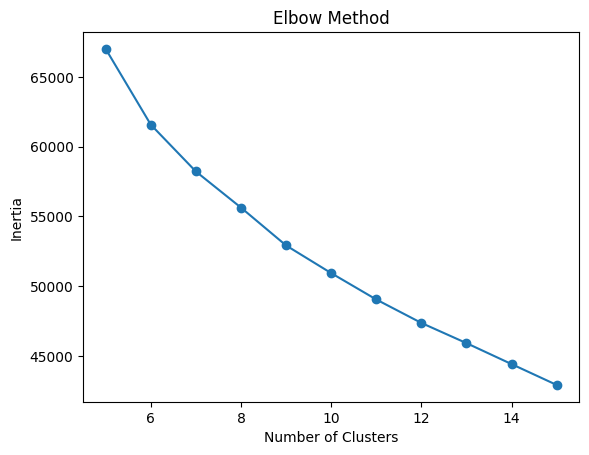

In [ ]:
# plot for elbow method
plt.plot(xAxis, yAxis, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

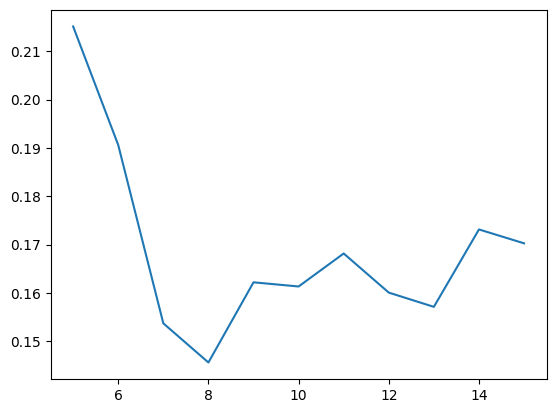

In [ ]:
# plot for fluctuation of silhouette score
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

silhouette_scores = [t[0] for t in score_tuple]

ks = [t[1] for t in score_tuple]

plt.plot(ks, silhouette_scores)

In [ ]:
last_category

['Science & Technology',
 'Entertainment',
 'Film & Animation',
 'Howto & Style',
 'Sports',
 'People & Blogs',
 'Music',
 'Comedy',
 'Education',
 'News & Politics',
 'Gaming',
 'Autos & Vehicles',
 'Pets & Animals',
 'Travel & Events',
 'Nonprofits & Activism',
 'Shows']

In [ ]:
# Via Google Model, check similiarity between categories

#model.wv.similarity('Film & Animation', 'Entertainment')
# model.wv.similarity()
# model.wv.similarity()



from itertools import combinations

def words_combinations(word_list):
    word_combinations = list(combinations(word_list, 2))
    return word_combinations

combinations_list = words_combinations(last_category)
for word1, word2 in combinations_list:
  try:
    similarity = model.wv.similarity(word1.lower(), word2.lower())
    print(f"Similarity between '{word1.lower()}' and '{word2.lower()}: '{similarity}' ")
  except KeyError as e:
    pass


Similarity between 'entertainment' and 'sports: '0.423532634973526' 
Similarity between 'entertainment' and 'music: '0.5738862156867981' 
Similarity between 'entertainment' and 'comedy: '0.2660475969314575' 
Similarity between 'entertainment' and 'education: '0.5262415409088135' 
Similarity between 'entertainment' and 'gaming: '0.6456232666969299' 
Similarity between 'entertainment' and 'shows: '0.6075252890586853' 
Similarity between 'sports' and 'music: '0.7940084338188171' 
Similarity between 'sports' and 'comedy: '0.532311201095581' 
Similarity between 'sports' and 'education: '0.80872642993927' 
Similarity between 'sports' and 'gaming: '0.6214379668235779' 
Similarity between 'sports' and 'shows: '0.813616156578064' 
Similarity between 'music' and 'comedy: '0.7625649571418762' 
Similarity between 'music' and 'education: '0.9116653203964233' 
Similarity between 'music' and 'gaming: '0.7938221096992493' 
Similarity between 'music' and 'shows: '0.9928061366081238' 
Similarity between